# Exploration color & nutri facts

In [1]:
from healthy_candies.load import load_clean_rel_to_nutri, NUTRI_COLS

from os.path import join
from healthy_candies.path import STATIC_DATA_FOLDER
import pandas as pd
import numpy as np

COLORS_FILE = join(STATIC_DATA_FOLDER,'colors.csv.zip')

## Loading data

In [2]:
NUTRI_COLS

['energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'nutrition-score-fr_100g']

In [3]:
data = load_clean_rel_to_nutri(
    usecols=['code', 'main_category_en']+NUTRI_COLS, 
    filter_has_image=True)
data.head()

,code,main_category_en,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g
292,0000007020254,Beverages,213.0,0.0,0.0,14.0,0.0,0.0,1.000000,0.393701,12.0
411,0000027533024,Desserts,1284.0,7.0,3.6,54.2,44.0,3.9,0.200000,0.078740,11.0
412,0000027533048,Sugary snacks,1284.0,7.0,3.6,54.2,44.0,3.9,0.199898,0.078700,10.0
427,0000040608754,Beverages,177.0,0.0,0.0,10.4,10.4,0.0,0.025400,0.010000,13.0
531,0000087177756,Beverages,177.0,0.0,0.0,10.4,10.4,0.0,0.100000,0.039370,13.0


In [4]:
colors = pd.read_csv(COLORS_FILE, dtype={'code':str})
total_valid_pix = colors.total_valid_pix
colors = colors.drop(['total_pix', 'total_valid_pix'], axis=1)
colors.head()

,code,red,orange,magenta,pink,yellow,yellow-green,green,green-cyan,cyan,cyan-blue,blue,blue-magenta
0,0000007020254,484,127,0,0,0,0,0,0,0,0,0,0
1,0000027533024,219,708,0,0,2,0,0,0,0,0,0,0
2,0000027533048,100,51,0,0,2,0,0,0,0,0,0,0
3,0000040608754,1457,0,0,14,138,0,0,0,110,4014,1222,0
4,0000087177756,61,188,0,0,553,195,4,252,186,6,0,0


In [5]:
hues = list(colors.drop('code', axis=1).columns)
hues

['red',
 'orange',
 'magenta',
 'pink',
 'yellow',
 'yellow-green',
 'green',
 'green-cyan',
 'cyan',
 'cyan-blue',
 'blue',
 'blue-magenta']

### Cleaning

We keep only the values that are bigger than relevant threshold, that depends on the total valid pixels during extraction. We don't want to count a color if there is only 1 pixel that contains it.

In [6]:
colors_cleaned = colors.copy()
for col in hues:
    colors_cleaned[col] = (colors[col] > total_valid_pix/24) * 1
colors_cleaned.head()

,code,red,orange,magenta,pink,yellow,yellow-green,green,green-cyan,cyan,cyan-blue,blue,blue-magenta
0,0000007020254,1,1,0,0,0,0,0,0,0,0,0,0
1,0000027533024,1,1,0,0,0,0,0,0,0,0,0,0
2,0000027533048,1,1,0,0,0,0,0,0,0,0,0,0
3,0000040608754,1,0,0,0,0,0,0,0,0,1,1,0
4,0000087177756,1,1,0,0,1,1,0,1,1,0,0,0


Then, we can take a look at what product categories are present in the data

In [7]:
categories = colors_cleaned.merge(data, on='code').main_category_en
categories.value_counts().head(20)

Plant-based foods and beverages    10995
Sugary snacks                       6448
Dairies                             4877
Meats                               2736
Meals                               2348
Beverages                           2334
Groceries                           1922
Canned foods                        1209
Fruit juices                        1136
Frozen foods                        1130
Salty snacks                        1063
Seafood                              873
Desserts                             752
Spreads                              589
Sandwiches                           443
Fruit juices and nectars             237
Farming products                     204
Breakfasts                           147
Crêpes and galettes                  129
Pickles                              106
Name: main_category_en, dtype: int64

The first one is not a very relevant category.
Up to the Sandwiches there are enough product to conduct a relevant analysis. 

In [8]:
interesting_cats = list(categories.value_counts().head(15).tail(14).index)

### Look at the colors in each categories

In [9]:
merge = colors_cleaned.merge(data, on='code')
merge = merge[merge.main_category_en.isin(interesting_cats)]

In [10]:
merge[['main_category_en', 'cyan']].groupby(by='main_category_en').mean().plot.bar(color='cyan')
a = 1

### Looking at the number of columns

In [11]:
colors_simple = colors_cleaned[['code']].copy()
colors_simple['hue_count'] = colors_cleaned[hues].sum(axis=1)
colors_simple.head()

,code,hue_count
0,0000007020254,2
1,0000027533024,2
2,0000027533048,2
3,0000040608754,3
4,0000087177756,6


In [12]:
merged = data.merge(colors_simple, on='code')
merged = merged[merged.main_category_en.isin(interesting_cats)]

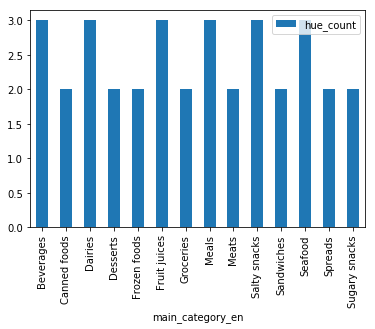

In [13]:
merged[['main_category_en', 'hue_count']].groupby(by='main_category_en').median().plot.bar()


In [14]:
# tmp=merged[['main_category_en', 'hue_count']].groupby(by='main_category_en')
# tmp.quantile(np.linspace(0, 1, 100)).plot.bar(by='main_category_en')